In [36]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import ssl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# 创建一个不验证证书的 SSL 上下文
ssl._create_default_https_context = ssl._create_unverified_context

<img src="./images/SGD.png" alt="示例图片" width="1100">

In [10]:
X, Y = fetch_california_housing(return_X_y=True)
X.shape, Y.shape

((20640, 8), (20640,))

In [14]:
# 将 X 和 Y 合并到一个 DataFrame 中
# X 是一个二维数组，Y 是一个一维数组，因此我们需要将 Y 转换成一个列
df = pd.DataFrame(X[:10], columns=[f'Feature_{i}' for i in range(X[:10].shape[1])])

# 将 Y 加入到 DataFrame 中作为一个新列
df['Target'] = Y[:10]

# 打印前10行数据
print(df)

   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0     8.3252       41.0   6.984127   1.023810      322.0   2.555556   
1     8.3014       21.0   6.238137   0.971880     2401.0   2.109842   
2     7.2574       52.0   8.288136   1.073446      496.0   2.802260   
3     5.6431       52.0   5.817352   1.073059      558.0   2.547945   
4     3.8462       52.0   6.281853   1.081081      565.0   2.181467   
5     4.0368       52.0   4.761658   1.103627      413.0   2.139896   
6     3.6591       52.0   4.931907   0.951362     1094.0   2.128405   
7     3.1200       52.0   4.797527   1.061824     1157.0   1.788253   
8     2.0804       42.0   4.294118   1.117647     1206.0   2.026891   
9     3.6912       52.0   4.970588   0.990196     1551.0   2.172269   

   Feature_6  Feature_7  Target  
0      37.88    -122.23   4.526  
1      37.86    -122.22   3.585  
2      37.85    -122.24   3.521  
3      37.85    -122.25   3.413  
4      37.85    -122.25   3.422  
5      37.85  

In [48]:
# 数据预处理
ones = np.ones(shape=(X.shape[0], 1)) # 创建全为1的列:
X = np.hstack([X, ones]) # np.hstack 用于按水平方向（即列方向）将 ones 数组添加到 X 的最后一列。
# 这里给数据矩阵 X 加了一个全 1 的列，用于表示偏置项。
validate_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validate_size, shuffle=True)

# batch 函数
def get_batch(batchsize: int, X: np.ndarray, Y: np.ndarray):
    assert 0 == X.shape[0] % batchsize, f'{X.shape[0]} % {batchsize} != 0'
    batchnum = X.shape[0] // batchsize
    
    X_new = X.reshape((batchnum, batchsize, X.shape[1]))
    Y_new = Y.reshape((batchnum, batchsize, )) # [batch_num, batch_size]
    
    for i in range(batchnum):
        yield X_new[i, :, :], Y_new[i, :]
        # yield 是一个用于生成器的关键字，它让函数返回一个值，同时保留当前的执行状态。每次调用生成器函数时，执行将从上次停止的地方继续。
        # yield 语句让函数变成生成器，它允许你在一次迭代中逐步返回多个值，而不是一次性返回所有值。
        '''
        def f():
            for i in range(10):
                return i
        def y():
            for i in range(10):
                yield i
        gen = y()
        for i in range(10):
            print(f(), gen, next(gen))  # 获取y生成器的下一个值
            
        0 <generator object y at 0x128904c70> 0
        0 <generator object y at 0x128904c70> 1
        0 <generator object y at 0x128904c70> 2
        0 <generator object y at 0x128904c70> 3
        0 <generator object y at 0x128904c70> 4
        0 <generator object y at 0x128904c70> 5
        0 <generator object y at 0x128904c70> 6
        0 <generator object y at 0x128904c70> 7
        0 <generator object y at 0x128904c70> 8
        0 <generator object y at 0x128904c70> 9
        '''

# 损失函数
def mse(X: np.ndarray, Y: np.ndarray, W: np.ndarray):
    return 0.5 * np.mean(np.square(X @ W - Y))
    # @ == .dot() == .matmul() 矩阵乘法 numpy / tensor / matrix
    # * 对应元素相乘 (Hadamard 积)

# MSE 损失函数对权重 W 的梯度
def diff_mse(X: np.ndarray, Y: np.ndarray, W: np.ndarray):
    return X.T @ (X @ W - Y) / X.shape[0]

def plot_loss(loss_train: np.ndarray, loss_validate: np.ndarray, validate_every: int):
    """
    绘制训练损失和验证损失随训练过程的变化。
    
    参数：
    - loss_train: 训练过程中的训练损失 (一个 numpy 数组，长度为训练周期数)
    - loss_validate: 验证损失 (一个 numpy 数组，长度为验证周期数)
    - validate_every: 每多少个训练周期进行一次验证
    """
    
    # 计算训练周期的数量
    epochs = np.arange(1, len(loss_train) + 1)

    # 绘制训练损失
    plt.plot(epochs, loss_train, label="Training Loss", color="blue", linestyle="-", linewidth=2)

    # 绘制验证损失
    validate_epochs = np.arange(validate_every, len(loss_train) + 1, validate_every)
    plt.plot(validate_epochs, loss_validate, label="Validation Loss", color="red", linestyle="--", linewidth=2)

    # 添加标题和标签
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # 显示图形
    plt.grid(True)
    plt.show()

In [63]:
# 模型训练
lr = 0.001
num_epochs = 1000
batch_size = 64
validate_every = 100
grad_clip_value = 1.0  # 梯度裁剪的最大值, 缓解梯度爆炸

def train(num_epochs: int, batch_size: int, validate_every: int, W0: np.ndarray, 
          X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray):
    loop = tqdm(range(num_epochs))
    loss_train = []
    loss_validate = []
    W = W0
    for epoch in loop:
        loss_train_epoch = 0
        for x_batch, y_batch in get_batch(64, X_train, Y_train): # [batch_num, batch_size, num_features]
            # x_batch: [batch_size, num_features]
            loss_batch = mse(X=x_batch, Y=y_batch, W=W)
            loss_train_epoch += loss_batch * x_batch.shape[0] / X_train.shape[0]
            grad = diff_mse(X=x_batch, Y=y_batch, W=W)
            # 梯度裁剪：确保梯度在 [-grad_clip_value, grad_clip_value] 范围内, 缓解梯度爆炸
            grad = np.clip(grad, -grad_clip_value, grad_clip_value)
            W = W - lr * grad
            
        loss_train.append(loss_train_epoch)
        loop.set_description(f'epoch: {epoch}, loss: {loss_train_epoch}')
        # set_description 是 tqdm 库提供的方法，用来设置进度条的描述文本。
        # 这个描述文本会显示在进度条的左侧。每次调用 set_description，它都会更新进度条的描述内容。
        
        if 0 == epoch % validate_every:
            loss_validate_epoch = mse(X=X_test, Y=Y_test, W=W)
            loss_validate.append(loss_validate_epoch)
            print('=========================Validate=========================')
            print(f'Epoch: {epoch}, train_loss: {loss_train_epoch}, val_loss: {loss_validate_epoch}')
            print("'=========================================================")
    
    plot_loss(np.array(loss_train), np.array(loss_validate), validate_every)

epoch: 0, loss: 1558.5595832405343:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 10, loss: 30.83598231782395:   1%|          | 10/1000 [00:00<00:21, 45.75it/s]

=========================Validate=========================
Epoch: 0, train_loss: 1558.5595832405343, val_loss: 877.2441243309844
'=========================================================


epoch: 115, loss: 1.6175570452739767:  11%|█         | 112/1000 [00:01<00:10, 83.09it/s]

=========================Validate=========================
Epoch: 100, train_loss: 1.617632349035164, val_loss: 1.6600972593960204
'=========================================================


epoch: 219, loss: 1.629928670748086:  22%|██▏       | 218/1000 [00:02<00:08, 90.69it/s] 

=========================Validate=========================
Epoch: 200, train_loss: 1.627164669905432, val_loss: 1.656052641124393
'=========================================================


epoch: 319, loss: 1.641965357239037:  32%|███▏      | 318/1000 [00:03<00:08, 78.23it/s] 

=========================Validate=========================
Epoch: 300, train_loss: 1.639990500960069, val_loss: 1.6908549519807095
'=========================================================


epoch: 419, loss: 1.6509382175385545:  42%|████▏     | 418/1000 [00:04<00:06, 93.66it/s]

=========================Validate=========================
Epoch: 400, train_loss: 1.6493536954633896, val_loss: 1.7021439296402736
'=========================================================


epoch: 520, loss: 1.6576334725294644:  52%|█████▏    | 518/1000 [00:06<00:05, 94.60it/s]

=========================Validate=========================
Epoch: 500, train_loss: 1.656380763480867, val_loss: 1.7080085950938106
'=========================================================


epoch: 618, loss: 1.662789829270535:  61%|██████▏   | 614/1000 [00:07<00:04, 86.22it/s] 

=========================Validate=========================
Epoch: 600, train_loss: 1.6618513933730847, val_loss: 1.7148251330658246
'=========================================================


epoch: 719, loss: 1.6668024454365244:  71%|███████▏  | 714/1000 [00:08<00:03, 91.19it/s]

=========================Validate=========================
Epoch: 700, train_loss: 1.6661212104409122, val_loss: 1.7224660763008677
'=========================================================


epoch: 818, loss: 1.6693164377409533:  81%|████████▏ | 813/1000 [00:09<00:02, 90.25it/s]

=========================Validate=========================
Epoch: 800, train_loss: 1.6691051930430783, val_loss: 1.7259687607659464
'=========================================================


epoch: 918, loss: 1.6715882940569133:  91%|█████████▏| 913/1000 [00:10<00:00, 93.72it/s]

=========================Validate=========================
Epoch: 900, train_loss: 1.6712906495750004, val_loss: 1.7293293200027982
'=========================================================


epoch: 999, loss: 1.67277819808819: 100%|██████████| 1000/1000 [00:11<00:00, 87.56it/s] 


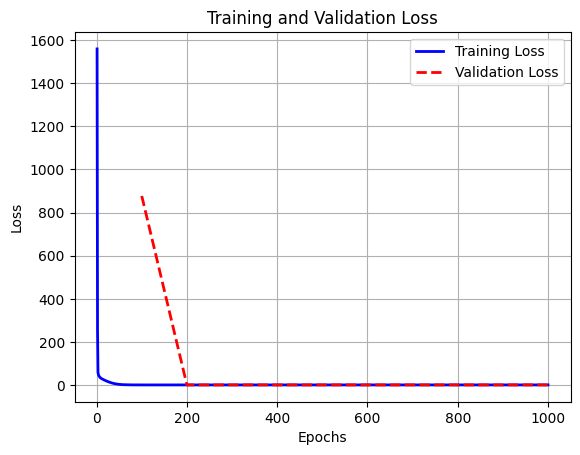

In [64]:
W0 = np.random.random(size=(X.shape[1], )) # 初始权重
# W0 = np.random.uniform(-np.sqrt(6. / X.shape[1]), np.sqrt(6. / X.shape[1]), size=(X.shape[1],)) # 使用 Xavier 初始化
train(num_epochs=num_epochs, batch_size=batch_size, validate_every=validate_every, W0=W0, 
      X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)